# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

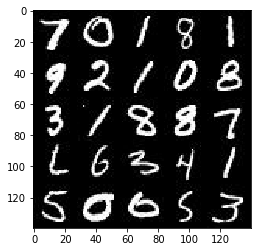

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

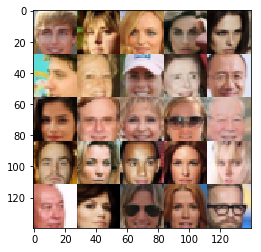

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
import numpy as np

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, shape = [None, image_height, image_width,image_channels], name="inputs")
    z_dim = tf.placeholder(tf.float32, shape = [None, z_dim], name="z_dim")
    learning_rate = tf.placeholder(tf.float32, shape = None, name="learning_rate")
    return inputs, z_dim, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    ims = images.get_shape().as_list()
    print(ims)
    ims = np.product(ims[1:])
    
    with tf.variable_scope("discriminator",
                           reuse = reuse):
        discriminator = images
        discriminator = tf.reshape(discriminator, [-1, ims])
        #discriminator = tf.contrib.slim.flatten(discriminator)
        print("ds: ",discriminator.get_shape().as_list())
        discriminator = tf.contrib.layers.fully_connected(
            discriminator, num_outputs= int(ims*0.5), activation_fn = None)
        discriminator = tf.maximum(discriminator, tf.multiply(0.01, discriminator))
        
        discriminator = tf.contrib.layers.fully_connected(
            discriminator, num_outputs= int(ims*0.25), activation_fn = None)
        discriminator = tf.maximum(discriminator, tf.multiply(0.01, discriminator))
    
        discriminator = tf.layers.dense(
            discriminator, 1, activation = None)
    
        #discriminator = tf.reshape(discriminator, [-1, 1])
        print("ds out: ",discriminator.get_shape().as_list())
        out = tf.sigmoid( discriminator )
    return out, discriminator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

[None, 28, 28, 3]
ds:  [None, 2352]
ds out:  [None, 1]
[None, 28, 28, 3]
ds:  [None, 2352]
ds out:  [None, 1]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    imside = 28
    ims = imside*imside*out_channel_dim
    with tf.variable_scope("generator",
                           reuse = not is_train):
        generator = z
        generator = tf.contrib.layers.fully_connected(
            generator, num_outputs= int(ims*0.125), activation_fn = None)
        generator = tf.maximum(generator, tf.multiply(0.01, generator))
        
        generator = tf.contrib.layers.fully_connected(
           generator, num_outputs= int(ims*0.25), activation_fn = None)
        generator = tf.maximum(generator, tf.multiply(0.01, generator))
    
        generator = tf.contrib.layers.fully_connected(
            generator, num_outputs = ims, activation_fn = None)
        out = tf.tanh( generator )
        out = tf.reshape(out, [-1, imside, imside, out_channel_dim])
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    geneo = generator(input_z, out_channel_dim)
    discor, disclr = discriminator(input_real)
    discof, disclf = discriminator(geneo, reuse = True)
    
    dislossr = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disclr, 
            labels=0.9*tf.ones_like(disclr)))
    
    dislossf = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disclf, 
            labels=tf.zeros_like(disclf)))
    
    disloss = dislossf + dislossr
    
    genloss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disclf, 
            labels=tf.ones_like(disclf)))
    
    
    return disloss, genloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

[None, 28, 28, 4]
ds:  [None, 3136]
ds out:  [None, 1]
[None, 28, 28, 4]
ds:  [None, 3136]
ds out:  [None, 1]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable = tf.trainable_variables()
    genew = [ w for w in trainable 
             if "generator/" in w.name]
    genewTo = tf.train.AdamOptimizer(
        learning_rate, beta1 = beta1).minimize(
        g_loss, var_list=genew)
    
    discw = [ w for w in trainable 
             if "discriminator/" in w.name]
    discwTo = tf.train.AdamOptimizer(
        learning_rate, beta1 = beta1).minimize(
        d_loss, var_list=discw)
    
    return discwTo, genewTo


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time
import tqdm

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    input_channels = data_shape[3] #int(3 if data_image_mode == "RGB" else 1) 
    
    print ("input channels: ", input_channels,", data_shape: ", data_shape)
    input_real, input_z, learning_rt = model_inputs(
        data_shape[1], data_shape[2], input_channels, z_dim)
          
    
    d_loss,  g_loss = model_loss(input_real, input_z, input_channels)
    d_train, g_train = model_opt(d_loss, g_loss, learning_rt, beta1)
    start_time = time.time()
    saver = tf.train.Saver()
    i=0
    #!mkdir "./savedmodel"  
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i=i+1
                #saver.save(sess, './savedmodel/model.ckpt')
                #fileWriter = tf.summary.FileWriter("./savedmodel", graph=sess.graph)
                #fileWriter.flush()
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print("batch shape z:", batch_z.shape, " im:", batch_images.shape)
                sess.run(d_train, feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z,
                    learning_rt: learning_rate
                })
                
                sess.run(g_train, feed_dict = {
                    input_z: batch_z,
                    learning_rt: learning_rate
                })
                if(0 == i % 100):
                    d_accute_loss = sess.run(d_loss, feed_dict = {
                        input_real: batch_images,
                        input_z: batch_z
                    })

                    g_accute_loss = sess.run(g_loss, feed_dict = {
                        input_z: batch_z
                    })

                    tspan = start_time - time.time()
                    eta = (int(60000 * tspan/(i+1)))
                    print("\r Ep: {:03d}/{:3d} DL:{:.4f} GL:{:.4f} time:{}/{}".format(
                        epoch_i, epoch_count, d_accute_loss, g_accute_loss, tspan, eta))

                    show_generator_output(sess, 16, input_z, input_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

input channels:  1 , data_shape:  (60000, 28, 28, 1)
[None, 28, 28, 1]
ds:  [None, 784]
ds out:  [None, 1]
[None, 28, 28, 1]
ds:  [None, 784]
ds out:  [None, 1]
 Ep: 000/  2 DL:1.3357 GL:0.8257 time:-5.803211212158203/-3447


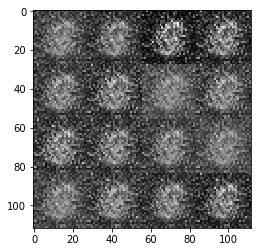

 Ep: 000/  2 DL:1.3898 GL:0.6579 time:-10.387148141860962/-3100


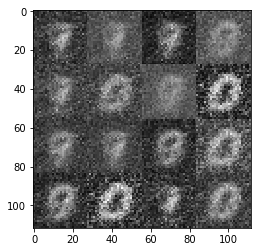

 Ep: 000/  2 DL:1.3093 GL:0.7740 time:-15.030683040618896/-2996


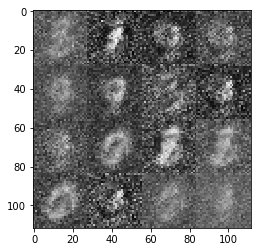

 Ep: 000/  2 DL:1.3221 GL:0.7275 time:-19.630163192749023/-2937


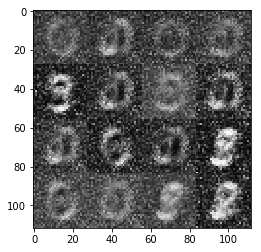

 Ep: 000/  2 DL:1.3552 GL:0.7949 time:-24.1733238697052/-2895


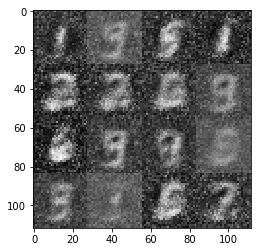

 Ep: 000/  2 DL:1.3770 GL:0.7804 time:-28.7510085105896/-2870


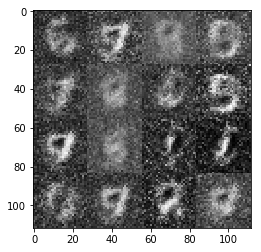

 Ep: 000/  2 DL:1.3820 GL:0.7741 time:-33.38142967224121/-2857


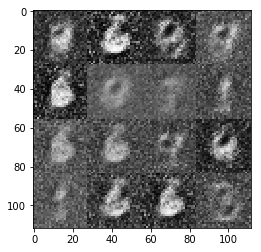

 Ep: 000/  2 DL:1.3756 GL:0.7871 time:-38.039403438568115/-2849


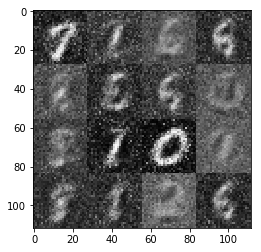

 Ep: 000/  2 DL:1.3743 GL:0.7910 time:-42.82611918449402/-2851


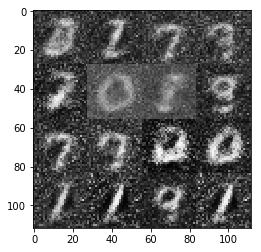

 Ep: 001/  2 DL:1.3703 GL:0.8106 time:-47.50476264953613/-2847


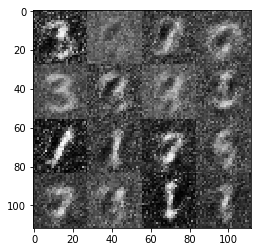

 Ep: 001/  2 DL:1.3726 GL:0.8215 time:-52.09609770774841/-2839


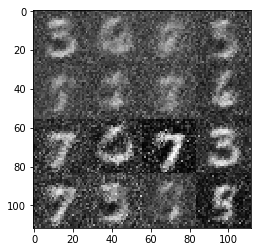

 Ep: 001/  2 DL:1.3756 GL:0.7821 time:-56.758666038513184/-2835


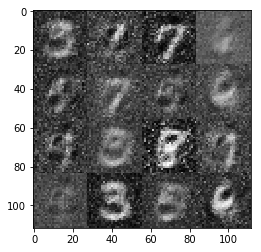

 Ep: 001/  2 DL:1.3711 GL:0.8261 time:-61.419028759002686/-2832


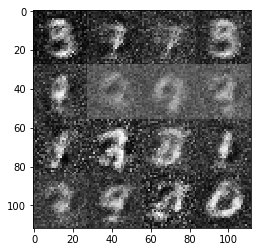

 Ep: 001/  2 DL:1.3721 GL:0.8076 time:-66.16533279418945/-2833


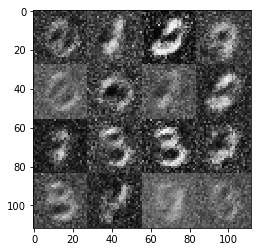

 Ep: 001/  2 DL:1.3726 GL:0.7866 time:-70.7815773487091/-2829


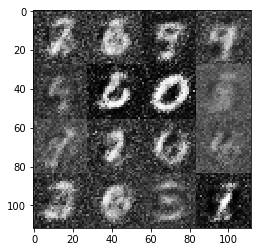

 Ep: 001/  2 DL:1.3777 GL:0.8153 time:-75.41924834251404/-2826


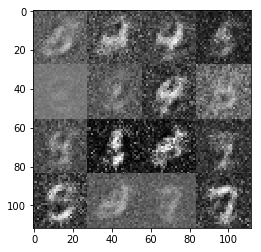

 Ep: 001/  2 DL:1.3697 GL:0.7818 time:-80.03127121925354/-2822


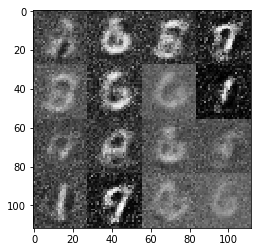

 Ep: 001/  2 DL:1.3853 GL:0.7387 time:-84.65962767601013/-2820


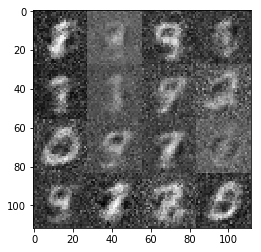

In [12]:
batch_size = 64
z_dim = 80
learning_rate = 0.0031
beta1 = 0.001
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

input channels:  3 , data_shape:  (202599, 28, 28, 3)
[None, 28, 28, 3]
ds:  [None, 2352]
ds out:  [None, 1]
[None, 28, 28, 3]
ds:  [None, 2352]
ds out:  [None, 1]
 Ep: 000/  1 DL:0.7933 GL:1.6592 time:-16.507972240447998/-9806


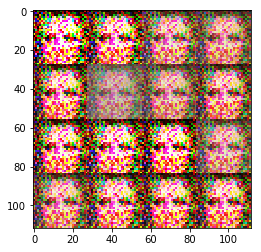

 Ep: 000/  1 DL:0.7784 GL:1.5885 time:-32.785160541534424/-9786


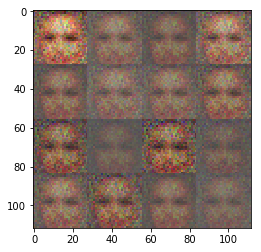

 Ep: 000/  1 DL:1.1878 GL:0.6223 time:-49.07881736755371/-9783


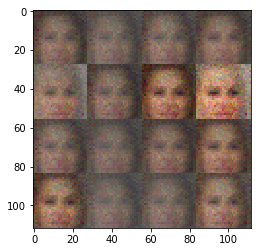

 Ep: 000/  1 DL:0.9969 GL:0.9481 time:-65.34510922431946/-9777


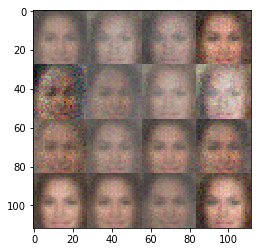

 Ep: 000/  1 DL:1.1763 GL:0.9505 time:-81.56721019744873/-9768


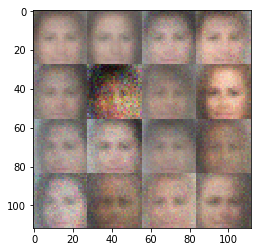

 Ep: 000/  1 DL:1.1882 GL:1.0246 time:-98.17583394050598/-9801


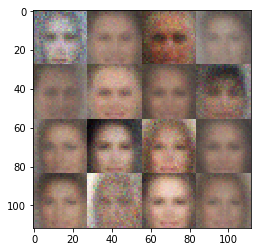

 Ep: 000/  1 DL:1.1147 GL:1.0152 time:-114.60032749176025/-9808


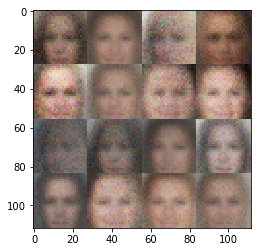

 Ep: 000/  1 DL:1.1003 GL:0.9457 time:-130.87326049804688/-9803


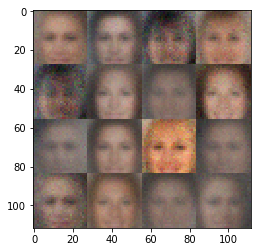

 Ep: 000/  1 DL:1.2548 GL:0.8548 time:-147.29911422729492/-9809


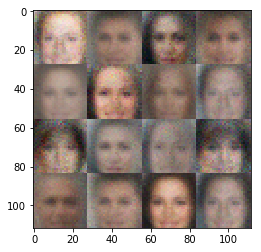

 Ep: 000/  1 DL:1.0538 GL:0.9585 time:-163.5010862350464/-9800


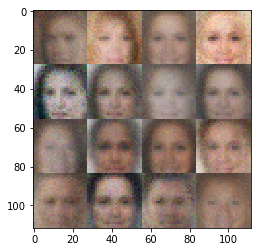

 Ep: 000/  1 DL:1.1850 GL:1.0052 time:-179.78814101219177/-9797


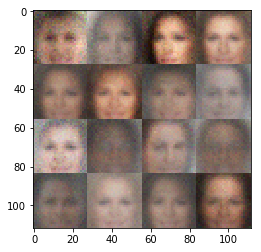

 Ep: 000/  1 DL:1.0633 GL:0.8650 time:-196.04361248016357/-9794


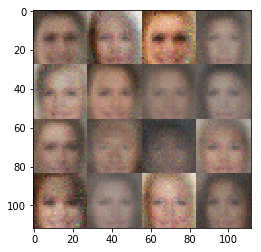

 Ep: 000/  1 DL:1.2089 GL:1.0120 time:-212.25389909744263/-9788


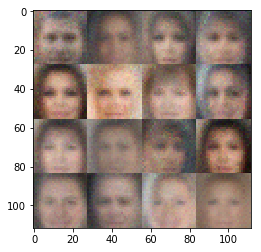

 Ep: 000/  1 DL:1.2440 GL:0.7618 time:-228.6375777721405/-9791


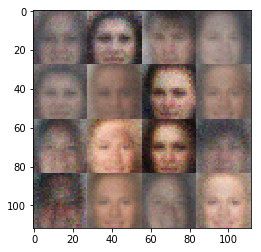

 Ep: 000/  1 DL:1.1047 GL:1.0006 time:-245.01770973205566/-9794


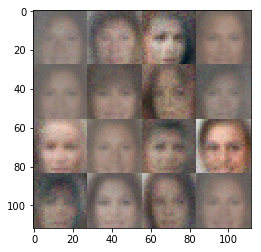

 Ep: 000/  1 DL:1.1506 GL:1.0146 time:-261.33867955207825/-9794


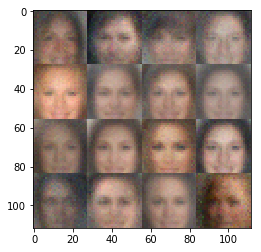

 Ep: 000/  1 DL:0.4448 GL:5.7842 time:-277.97862792015076/-9805


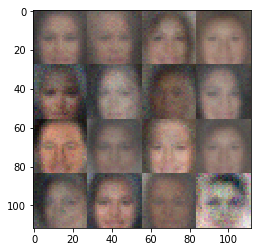

 Ep: 000/  1 DL:1.1185 GL:1.1374 time:-294.4422330856323/-9809


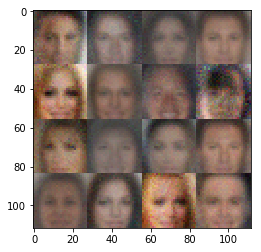

 Ep: 000/  1 DL:1.1940 GL:0.8415 time:-310.9111866950989/-9813


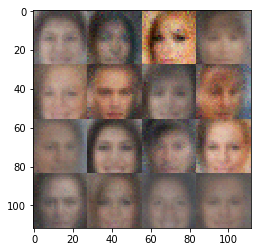

 Ep: 000/  1 DL:0.6086 GL:3.2702 time:-327.37703371047974/-9816


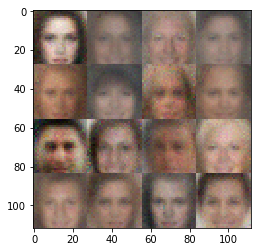

 Ep: 000/  1 DL:0.5404 GL:4.1235 time:-347.3695766925812/-9920


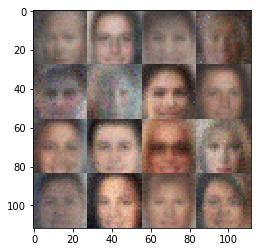

 Ep: 000/  1 DL:0.8635 GL:1.4186 time:-368.26994252204895/-10039


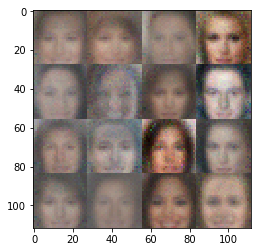

 Ep: 000/  1 DL:0.5031 GL:4.7704 time:-388.9916980266571/-10143


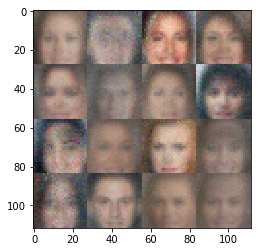

 Ep: 000/  1 DL:1.0680 GL:20.5817 time:-409.85769057273865/-10242


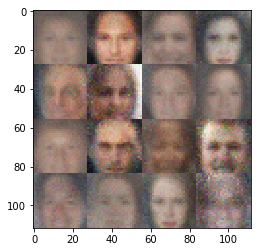

 Ep: 000/  1 DL:0.8677 GL:2.3805 time:-430.6344344615936/-10331


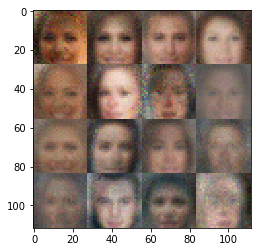

 Ep: 000/  1 DL:0.5012 GL:17.1383 time:-451.51495480537415/-10415


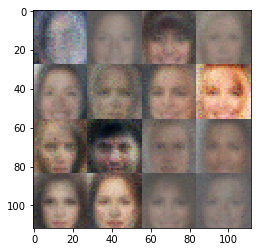

 Ep: 000/  1 DL:0.7645 GL:5.3956 time:-472.2786657810211/-10491


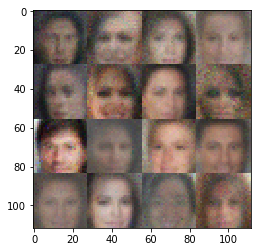

 Ep: 000/  1 DL:0.5076 GL:9.3760 time:-493.2952136993408/-10566


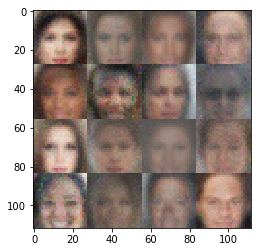

 Ep: 000/  1 DL:0.4321 GL:19.0755 time:-514.205911397934/-10635


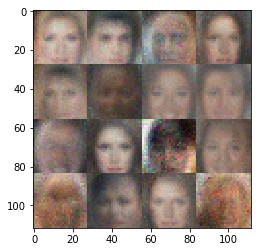

 Ep: 000/  1 DL:0.8316 GL:2.5408 time:-534.9658246040344/-10695


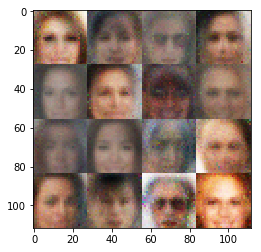

 Ep: 000/  1 DL:0.5049 GL:12.5479 time:-555.819296836853/-10754


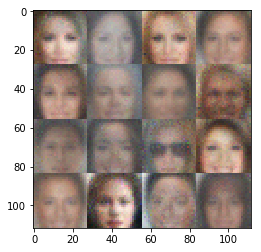

In [13]:
batch_size = 64
z_dim = 80
learning_rate = 0.0031
beta1 = 0.001


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.